# Tensorflow GPU常用配置方法
* 禁用GPU
        #禁用gpu版本TensorFlow，因为CUDA号码从0开始，这里直接让CUDA使用-1的GPU，自然就无法使用gpu了。
        代码前面加入：
        import os
        os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
        import tensorflow as tf

        Environment Variable Syntax    Results
        CUDA_VISIBLE_DEVICES=1    Only device 1 will be seen
        CUDA_VISIBLE_DEVICES=0,1    Devices 0 and 1 will be visible
        CUDA_VISIBLE_DEVICES="0,1"    Same as above, quotation marks are optional
        CUDA_VISIBLE_DEVICES=0,2,3    Devices 0, 2, 3 will be visible; device 1 is masked
        
* 设置使用GPU的百分比
    进行配置，使用30%的GPU
        config.gpu_options.per_process_gpu_memory_fraction = 0.3
    需要注意的是，虽然代码或配置层面设置了对显存占用百分比阈值，但在实际运行中如果达到了这个阈值，程序有需要的话还是会突破这个阈值。
    换而言之如果跑在一个大数据集上还是会用到更多的显存。以上的显存限制仅仅为了在跑小数据集时避免对显存的浪费而已。

* GPU按需使用
        config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配


#### 参考资料
    Tensorflow会话的配置项
    https://www.jianshu.com/p/b9a442bcfd2e    
    keras指定运行时显卡及限制GPU用量
    https://blog.csdn.net/A632189007/article/details/77978058
    

### GPU配置
    import keras 自动创建session会话，需要在任何import keras前进行ConfigProto配置

In [1]:
#-----GPU配置-----
#  提示：在其他代码之前进行以下配置

#禁用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #-1:禁用,0-n启用第几块显卡，多个以逗号隔开

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

#ConfigProto配置
config = tf.ConfigProto()

#设置GPU的百分比，程序需要还是会突破阈值
config.gpu_options.per_process_gpu_memory_fraction = 1 #0-1之间的浮点数表示占用百分比
#GPU按需使用,不全部占满显存, 按需分配
config.gpu_options.allow_growth=True #True:按需分配,False:一次性满额分配

# 设置session
sess = tf.Session(config=config)
KTF.set_session(sess)

Using TensorFlow backend.


# 测试范例

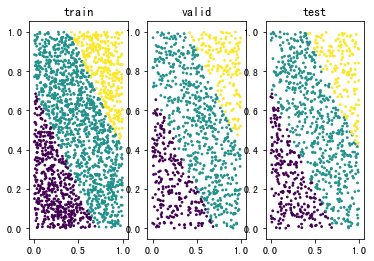

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
num_train=2000
num_valid=1000
num_test =1000

#========构造数据=======
#构造训练数据
x_train=np.random.rand(num_train,2)
y_train=np.sum(x_train,axis=1)
y_train[np.where((y_train<=0.7))[0]]=0
y_train[np.where((y_train>0.7)&(y_train<=1.4))[0]]=1
y_train[np.where((y_train>1.4))[0]]=2
#构造校验数据
x_valid=np.random.rand(num_valid,2)
y_valid=np.sum(x_valid,axis=1)
y_valid[np.where((y_valid<=0.7))[0]]=0
y_valid[np.where((y_valid>0.7)&(y_valid<=1.4))[0]]=1
y_valid[np.where((y_valid>1.4))[0]]=2
#构造测试数据
x_test =np.random.rand(num_test,2)
y_test=np.sum(x_test,axis=1)
y_test[np.where((y_test<=0.7))[0]]=0
y_test[np.where((y_test>0.7)&(y_test<=1.4))[0]]=1
y_test[np.where((y_test>1.4))[0]]=2

#======绘制散点图======
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.scatter(x_train[:,0], x_train[:,1], s=3, c=y_train)
plt.title('train')
plt.subplot(1,3,2)
plt.scatter(x_valid[:,0], x_valid[:,1], s=3, c=y_valid)
plt.title('valid')
plt.subplot(1,3,3)
plt.scatter(x_test[:,0], x_test[:,1], s=3, c=y_test)
plt.title('test')
plt.show()

In [3]:
import keras
from keras import models,layers,optimizers
from keras.utils.np_utils import to_categorical

#=======构建模型=======
model=models.Sequential()
model.add(layers.Dense(40,input_shape=(2,), activation='relu',name='dense_1'))
model.add(layers.Dense(20, activation='relu',name='dense_2'))
model.add(layers.Dense(10, activation='relu',name='dense_3'))
model.add(layers.Dense(4, activation='relu',name='dense_4'))
model.add(layers.Dense(3, activation='softmax',name='dense_0'))
#打印模型
model.summary()
#模型编译
model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.RMSprop(lr=1e-4),
          metrics=['acc'])
#=======模型训练========
y_train_labels = to_categorical(y_train)
model.fit(x_train,y_train_labels,epochs=100,validation_split=0.2)
#=======模型估计========
y_valid_labels=to_categorical(y_valid)
y_eval=model.evaluate(x_valid, y_valid_labels)
print('模型估计:',y_eval)

#=======模型预测========
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#=======正确率统计======
y_pred=np.reshape(y_pred,(-1))
acc=1.0-np.count_nonzero(y_pred-y_test)*1.0/len(y_pred)
print('acc:',acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_0 (Dense)              (None, 3)                 15        
Total params: 1,209
Trainable params: 1,209
Non-trainable params: 0
_________________________________________________________________
Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 0s 152us/step - loss: 1.1024 - acc: 

1600/1600 [==============================] - 0s 72us/step - loss: 0.5452 - acc: 0.9281 - val_loss: 0.5335 - val_acc: 0.9350
Epoch 54/100
1600/1600 [==============================] - 0s 73us/step - loss: 0.5250 - acc: 0.9356 - val_loss: 0.5125 - val_acc: 0.9425
Epoch 55/100
1600/1600 [==============================] - 0s 69us/step - loss: 0.5056 - acc: 0.9425 - val_loss: 0.4935 - val_acc: 0.9475
Epoch 56/100
1600/1600 [==============================] - 0s 70us/step - loss: 0.4866 - acc: 0.9437 - val_loss: 0.4749 - val_acc: 0.9500
Epoch 57/100
1600/1600 [==============================] - 0s 70us/step - loss: 0.4679 - acc: 0.9475 - val_loss: 0.4566 - val_acc: 0.9500
Epoch 58/100
1600/1600 [==============================] - 0s 79us/step - loss: 0.4501 - acc: 0.9487 - val_loss: 0.4387 - val_acc: 0.9575
Epoch 59/100
1600/1600 [==============================] - 0s 72us/step - loss: 0.4317 - acc: 0.9519 - val_loss: 0.4208 - val_acc: 0.9575
Epoch 60/100
1600/1600 [==============================